# Proyecto: Optimización del Proceso de Recepción y Registro de Problemas Técnicos en el Área de TI Usando IA Generativa

- Este proyecto implementa IA generativa para transcribir automáticamente los reportes de problemas técnicos de las computadoras recibidos por llamadas, agilizando el registro de incidentes y reduciendo errores.

In [64]:


import os
import json
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

from tqdm import tqdm
from dotenv import load_dotenv
from typing_extensions import TypedDict
from typing import Annotated, Any
from matplotlib.ticker import MaxNLocator
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.config import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate


## Cargando datos

In [5]:
 
def extract_all_values_from_transcript(file_path):
    values = []
    try:
        with open(file_path, 'r', encoding="utf-8") as f:
            data = json.load(f)
        
        # Recursive function to extract values from nested structures
        def extract_values(obj):
            if isinstance(obj, dict):
                for value in obj.values():
                    extract_values(value)
            elif isinstance(obj, list):
                for item in obj:
                    extract_values(item)
            else:
                values.append(obj)
        
        extract_values(data)
    
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
    
    return values

#  file path
file_path = "/Users/elvisrojasmonguia/Documents/Python courses/UTEC/hackaton 10/transcripciones.json"
transcriptions = extract_all_values_from_transcript(file_path)
 

In [69]:
 
# Choose one transcript randomly from the list
transcript_example = random.choice(transcriptions)

print("=" * 80)
print("Ejemplo de una llamada y su transcripcion:")
print("=" * 80)
print(f"\n\n{transcript_example}\n\n")


Ejemplo de una llamada y su transcripcion:


Persona 1:
 Hola, habla Elena de Soporte de TI. ¿En qué puedo asistirte?

 Persona 2:
 Buenos días, Elena. Soy Juan Alberto Pineda, de Finanzas. Tengo un inconveniente con el Excel: se cierra solo cuando abro archivos grandes.

 Persona 1:
 Comprendo. ¿Me confirmas tu código de empleado?

 Persona 2:
 Es 08764.

 Persona 1:
 Listo. ¿Desde qué fecha notaste este problema?

 Persona 2:
 Empezó hace dos días, el lunes por la mañana, a eso de las 10.

 Persona 1:
 ¿Te había sucedido antes?

 Persona 2:
 No, es la primera vez que me encuentro con este tipo de cierre inesperado.

 Persona 1:
 ¿Crees que sea software o hardware?

 Persona 2:
 Opino que es software, tal vez un conflicto con la versión de Office.

 Persona 1:
 De acuerdo. ¿El código de tu equipo?

 Persona 2:
 Es PC-FIN-909.

 Persona 1:
 Gracias, Juan Alberto. ¿Puedes darme tu número de teléfono y tu correo?

 Persona 2:
 Claro, mi número es 55-5050-6565 y mi correo japineda@empresa

## Entorno de Modelo LLM 

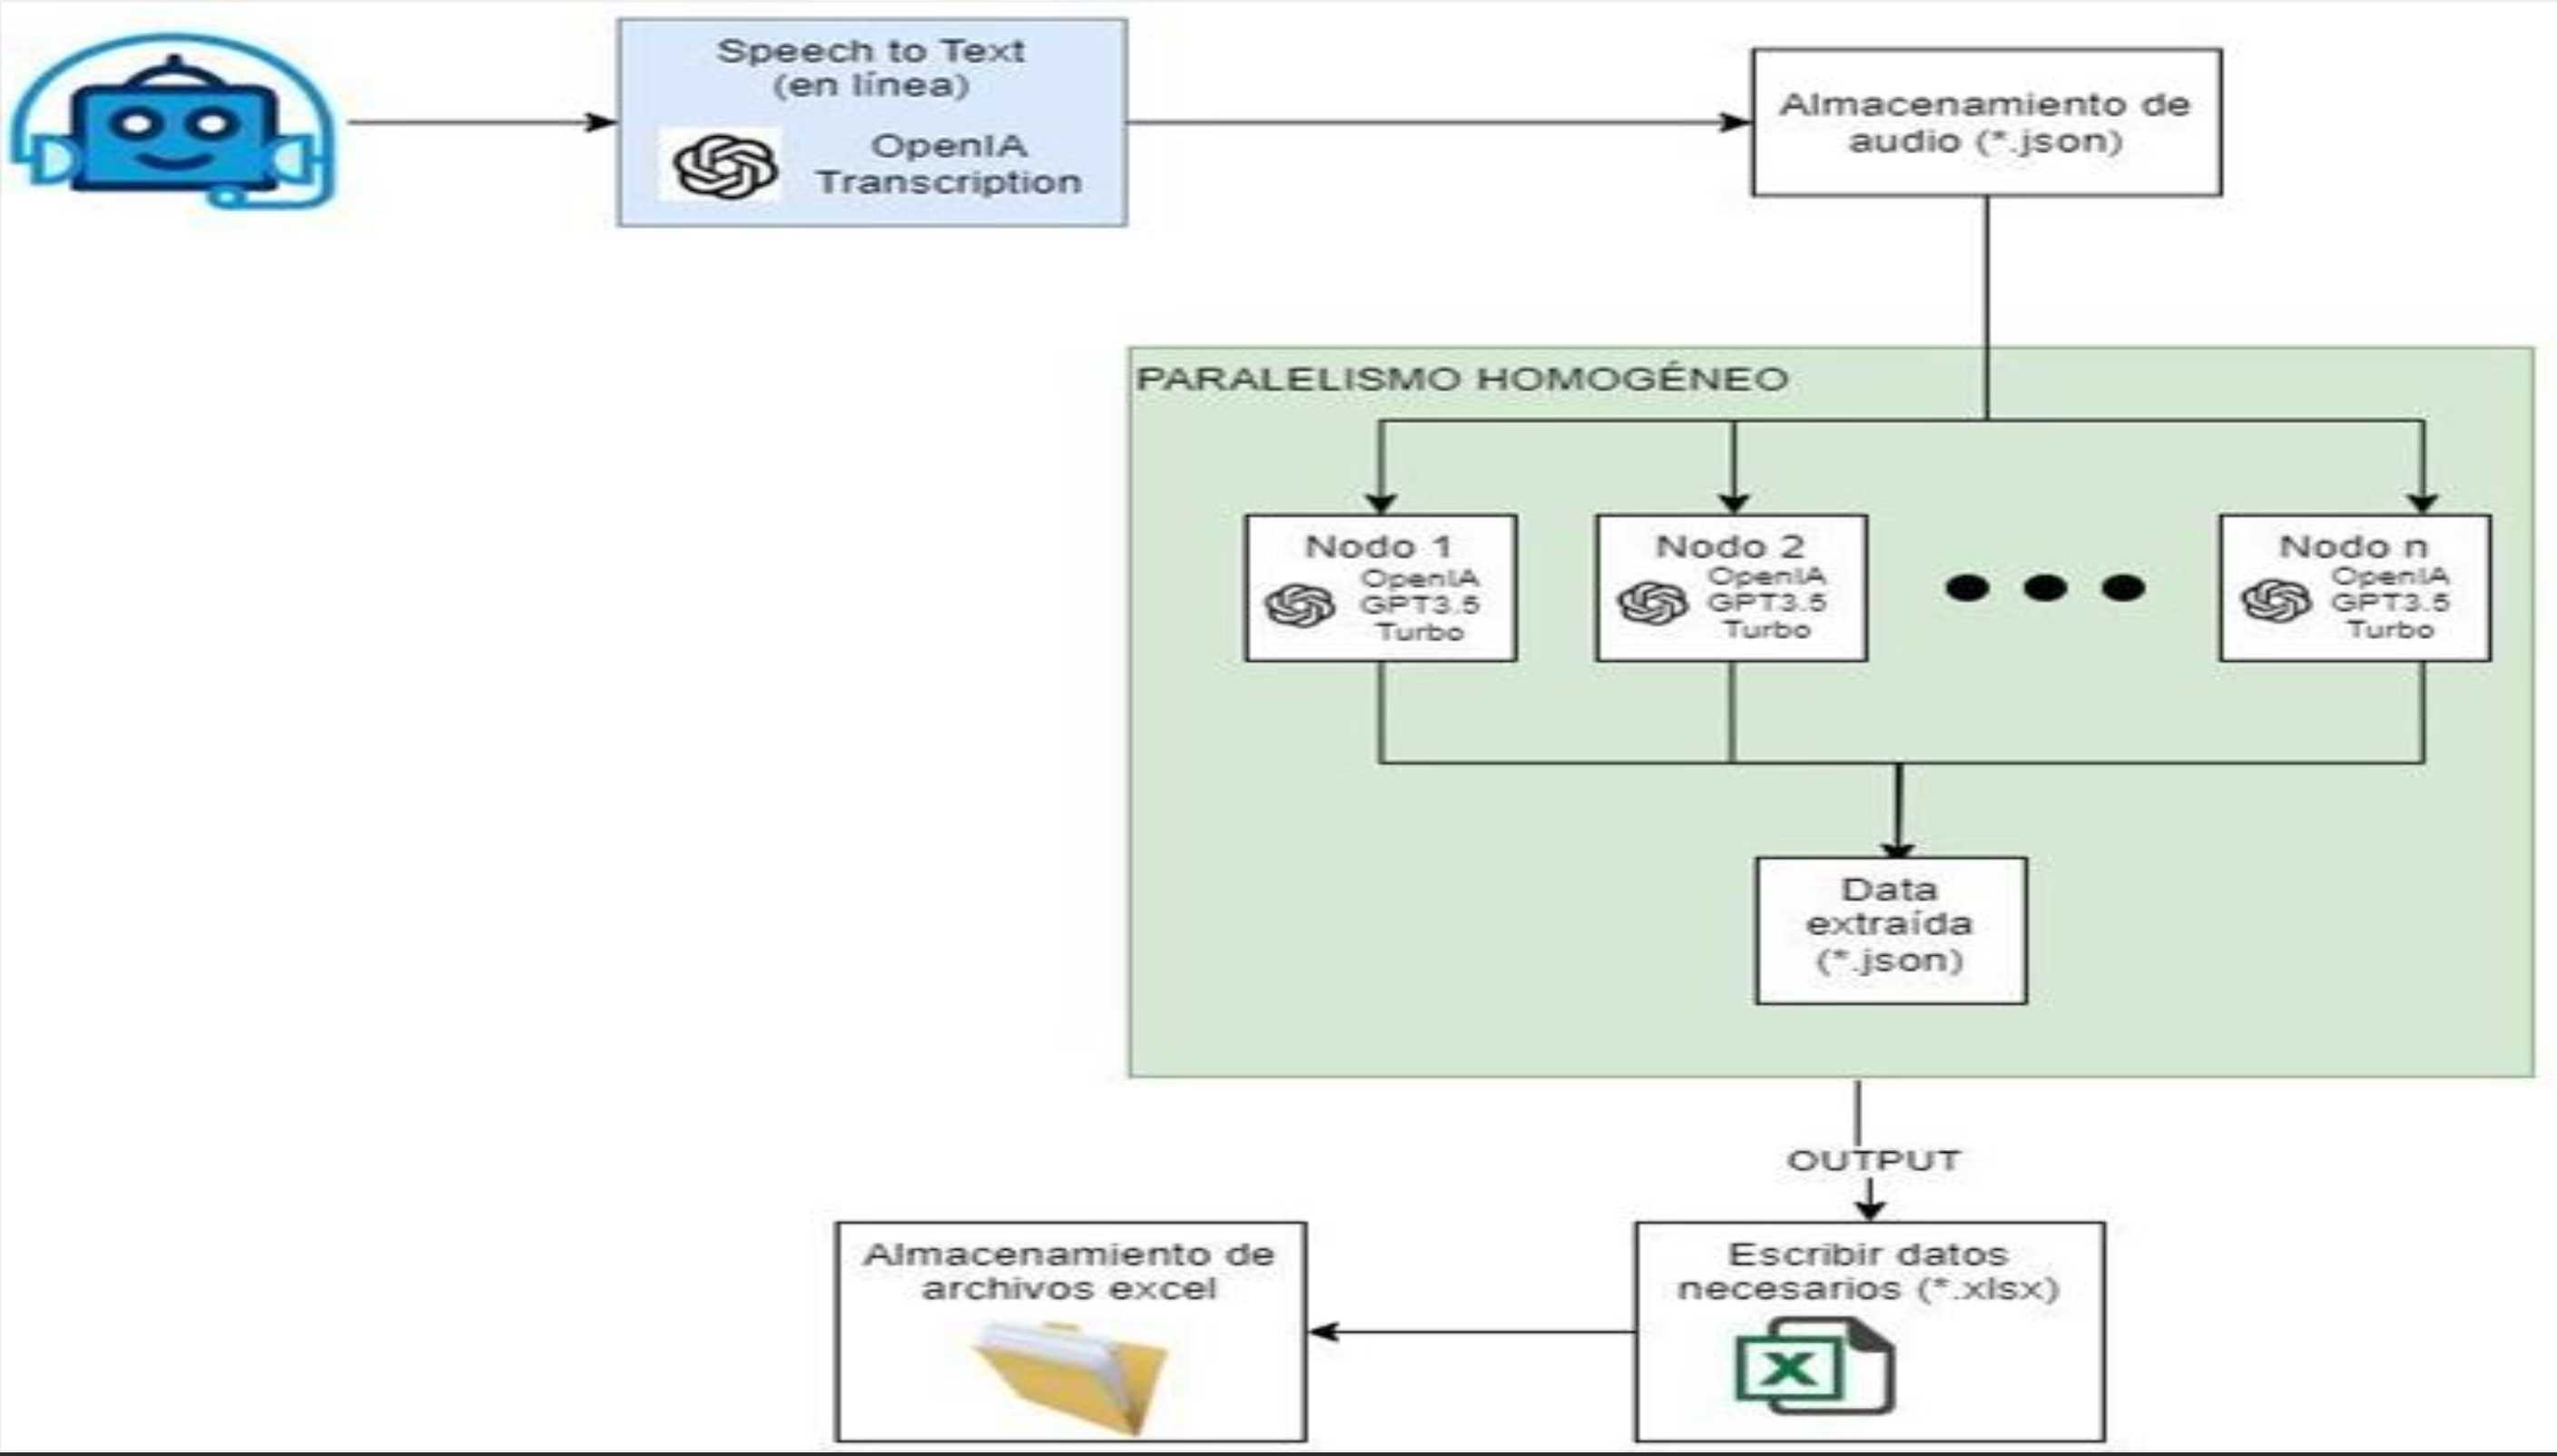

In [8]:
#Cargar variables de entorno
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

In [9]:
# ----------------------------------------------------------------------------------------
# ---------------------------------- Generar LLM  -------------------------------------
# ----------------------------------------------------------------------------------------
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=api_key)

In [10]:
systemPrompt = """ Eres un agente IA especializado en obtener y organizar información de transcripciones de reclamos realizados al área de TI. 
Tu tarea es analizar transcripciones de llamadas telefónicas y extraer información específica. 

- En todas las llamadas, **Persona 1** es el representante que recibe la llamada, y **Persona 2** es quien reporta el caso de falla.
- Cada llamada a analizar está delimitada por los caracteres `####`. 

Formato de la llamada:
#### {} #### 
"""

In [11]:
userPrompt = """ Eres un experto en TI que analiza transcripciones y realiza las siguientes actividades de extracción:

1. **Nombre solicitante** (Persona 2, ej: 'Antonio Vargas Luna')
2. **Nombre representante** (Persona 1, ej: 'Daniela')
3. **Área** (ej: 'Diseño Gráfico')
4. **Código empleado** (5 dígitos, ej: 03452)
5. **Resumen del problema** (basado en lo reportado por Persona 2)
6. **Fecha inicio** (formato YYYY-MM-DD)
7. **Recurrencia** ('primera vez', 'segunda vez', 'tercera vez')
8. **Tipo de problema** (software/hardware/ambos)
9. **Código equipo** (ej: PC-DISE-205)
10. **Teléfono** (ej: '55-1111-2222')
11. **Email / correo electrónico** (ej: 'usuario@empresa.com')
12. **Número ticket** (ej: 'TCK-2025-00001')

**Instrucciones adicionales:**
- Considera que la fecha de hoy es **2025-02-15**.
- Mapear áreas: 'Diseño' → 'Diseño Gráfico' (según catálogo).
- Para el **Resumen del problema**, usa SOLO la información proporcionada por Persona 2. No inventes causas.
- Para el **Tipo de problema**, mostrar "Indefinido" cuando no se pueda determinar si es hardware o software.
- En el **Resumen del problema**, incluye las causas enumeradas que identifiques relacionadas al problema.
- En el **Tipo de problema**, si no esta claro si es software/hardware/ambos, inputa una categoria de acuerdo a la causa mas probable.

**Formato de salida:**
Devolver un JSON con la siguiente estructura:
```json
{
  "solicitante": "Nombre solicitante",
  "representante": "Nombre representante",
  "area": "Área",
  "codigo_empleado": "Código empleado",
  "problema": "Resumen del problema",
  "fecha": "Fecha inicio",
  "recurrencia": "Recurrencia",
  "tipo_problema": "Tipo de problema",
  "equipo": "Código equipo",
  "telefono": "Teléfono",
  "email": "Email / correo electrónico",
  "nro_ticket": "Número ticket"
}

"""

In [12]:
# ----------------------------------------------------------------------------------------
# ----------------------------- ESTADO DE LOS NODOS  -------------------------------------
# ----------------------------------------------------------------------------------------
class State(TypedDict):
    aggregate: Annotated[list, operator.add]


# ----------------------------------------------------------------------------------------
# ----------------------------- CLASE GENERAL DE NODOS  ----------------------------------
# ----------------------------------------------------------------------------------------
class ReturnNodeValue:
    def __init__(self, node_name: str, llm_model, system_prompt: str, 
                 text_to_process: str, ai_request: str):
        self.node_name = node_name  # Nombre del nodo
        self.llm_model = llm_model   # Conexión al modelo LLM 
        self.system_prompt = system_prompt  # Prompt a nivel de sistema
        self.text_to_process = text_to_process  # Texto a procesar
        self.ai_request = ai_request    # Pregunta realizada al LLM

    def __call__(self, state: State) -> Any:

        messages = [("system", self.system_prompt.format(self.text_to_process)),
                    ("human", self.ai_request)]
        # Crea el agente y ejecuta
        if self.ai_request:
            try:
                respuestaIA = self.llm_model.invoke(messages)
                return {"aggregate": [{self.node_name: respuestaIA.content}]}
            except Exception as e:
                print(f"Error al ejecutar el agente para {self.node_name}: {e}")
                raise
        else:
            return {"aggregate": [""]}

In [13]:
# ----------------------------------------------------------------------------------------
# ------------------------------- Diseño de grafo  ---------------------------------------
# ----------------------------------------------------------------------------------------

builder = StateGraph(State)
for index, transcripcionesCliente in enumerate(transcriptions):
    node_name = f"nodo{index}"
    nodo = ReturnNodeValue(node_name, llm, systemPrompt, transcripcionesCliente, userPrompt)

    builder.add_node(node_name, nodo)
    
    builder.add_edge(START, node_name)
    builder.add_edge(node_name, END)

graph = builder.compile()
config_run = RunnableConfig(recursion_limit=3)

In [14]:
# ----------------------------------------------------------------------------------------
# ------------------------------ Ejecución del programa ----------------------------------
# ----------------------------------------------------------------------------------------
start_time = time.time()

llm_response = graph.invoke({"aggregate": []}, config_run)  

elapsed_time = time.time() - start_time
print(f"Tiempo de ejecución: {elapsed_time:.4f} segundos")


Tiempo de ejecución: 6.9220 segundos


In [35]:
print(f"Ejemplo de resultado de un nodo:\n\n{llm_response['aggregate'][0]}")

Ejemplo de resultado de un nodo:

{'nodo0': '```json\n{\n  "solicitante": "Antonio Vargas Luna",\n  "representante": "Daniela",\n  "area": "Diseño Gráfico",\n  "codigo_empleado": "03452",\n  "problema": "Apagones repentinos de la computadora, pantalla se pone negra antes de apagarse, computadora muy caliente en la parte trasera, problemas después de instalar actualización de Windows, pérdida de trabajo en proyectos de diseño",\n  "fecha": "2025-02-14",\n  "recurrencia": "primera vez",\n  "tipo_problema": "Hardware",\n  "equipo": "PC-DISE-205",\n  "telefono": "55-1111-2222",\n  "email": "avargas@empresa.com",\n  "nro_ticket": "TCK-2025-00001"\n}\n```'}


## Analisis de datos

In [25]:
data = []

# Procesar cada nodo en llm_response['aggregate']
for item in llm_response['aggregate']:
    for key, value in item.items():
        # Eliminar los marcadores ```json y ```, y cargar el JSON
        json_str = value.replace('```json\n', '').replace('\n```', '')
        json_data = json.loads(json_str)
        data.append(json_data)


In [59]:
# Convertir el reporte a un DataFrame
df = pd.DataFrame(data)
df.head(2)

,solicitante,representante,area,codigo_empleado,problema,fecha,recurrencia,tipo_problema,equipo,telefono,email,nro_ticket
0,Antonio Vargas Luna,Daniela,Diseño Gráfico,03452,"Apagones repentinos de la computadora, pantall...",2025-02-14,primera vez,Hardware,PC-DISE-205,55-1111-2222,avargas@empresa.com,TCK-2025-00001
1,Mónica Herrera Campos,Rodrigo,Compras,05678,Teclado deja de responder de repente. Problema...,2025-02-10,segunda vez,Hardware,PC-COMP-122,55-9999-8888,mherrera@empresa.com,TCK-2025-00002


In [38]:
for ii,jj in enumerate(df['problema']):
    print("="*60); print(f"Problema tecnico descrito por el trabajor {ii+1}"); print("="*60)
    print(f"\n {jj}\n\n") 

Problema tecnico descrito por el trabajor 1

 Apagones repentinos de la computadora, pantalla se pone negra antes de apagarse, computadora muy caliente en la parte trasera, problemas después de instalar actualización de Windows, pérdida de trabajo en proyectos de diseño


Problema tecnico descrito por el trabajor 2

 Teclado deja de responder de repente. Problema ocurre al tener varias pestañas de Chrome abiertas. Después de actualización de Windows se instaló un controlador nuevo para el teclado. Al reconectar el teclado, a veces el sistema no lo reconoce.


Problema tecnico descrito por el trabajor 3

 La computadora dejó de reconocer cualquier tipo de dispositivo USB. Posibles causas: 1) Actualización de Windows reciente. 2) Problemas con controladores tras la actualización. 3) Fallo en los puertos USB.


Problema tecnico descrito por el trabajor 4

 El software de gestión de personal se cierra al intentar cargar nuevos registros


Problema tecnico descrito por el trabajor 5

 Bucle

### Dashborad

In [45]:
 
# Configuración  de estilo
sns.set(style="whitegrid")
sns.set_palette("husl")
COLOR_1 = '#2ecc71'
COLOR_2 = '#e74c3c'


In [47]:
# Limpieza y preprocesamiento
df['tipo_problema'] = df['tipo_problema'].str.capitalize()
df['recurrencia']  = df['recurrencia'].str.lower()
df['tipo_equipo']  = df['equipo'].apply(lambda x: 'Laptop' if x.startswith('LAP') else 'PC')

In [49]:

 
def generate_analysis_report(df):

    # Crear figura para todos los gráficos
    fig = plt.figure(figsize=(18, 12), tight_layout=True)
    fig.suptitle('Análisis de Problemas Tecnológicos', fontsize=16, fontweight='bold',  y=1.02, )
    
    # -------------------------------------------
    # Gráfico 1: Problemas por área (Top 5)
    # -------------------------------------------
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    problems_by_area = df['area'].value_counts().nlargest(5)
    problems_by_area.plot(kind='barh', ax=ax1, color=COLOR_1)
    ax1.set_title('Top 5 Áreas con Más Problemas', pad=20)
    ax1.set_xlabel('Número de Problemas')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # -------------------------------------------
    # Gráfico 2: Distribución de Tipos de Problema
    # -------------------------------------------
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    problem_types = df['tipo_problema'].value_counts()
    problem_types.plot(kind='pie', autopct='%1.1f%%', ax=ax2,
                      wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax2.set_ylabel('')
    ax2.set_title('Distribución de Tipos de Problema', pad=20)
    
    # -------------------------------------------
    # Gráfico 3: Recurrencia de Problemas
    # -------------------------------------------
    ax3 = plt.subplot2grid((2, 2), (1, 0))
    recurrence_counts = df['recurrencia'].value_counts()
    recurrence_counts.plot(kind='bar', ax=ax3, color=COLOR_2)
    ax3.set_title('Frecuencia de Recurrencia de Problemas', pad=20)
    ax3.set_ylabel('Cantidad')
    ax3.set_xlabel('Número de veces reportado')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # -------------------------------------------
    # Gráfico 4: Relación entre Área y Tipo de Problema
    # -------------------------------------------
    ax4 = plt.subplot2grid((2, 2), (1, 1))
    cross_table = pd.crosstab(df['area'], df['tipo_problema']).nlargest(5, columns=df['tipo_problema'].unique())
    cross_table.plot(kind='bar', stacked=True, ax=ax4)
    ax4.set_title('Tipos de Problema por Área (Top 5)', pad=20)
    ax4.set_ylabel('Cantidad')
    ax4.legend(title='Tipo de Problema')
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------------------------
    # Análisis Adicional: Datos Clave
    # -------------------------------------------
    print("\nResumen Estadístico:")
    print(f"- Total de problemas reportados: {len(df)}")
    print(f"- Área con más problemas: {problems_by_area.idxmax()} ({problems_by_area.max()} reportes)")
    print(f"- Problema más común: {problem_types.idxmax()} ({problem_types.max()} casos)")
    print(f"- Porcentaje de problemas recurrentes: {(df['recurrencia'] != 'primera vez').mean():.1%}")
    
    print("\nRelaciones Clave:")
    recurring_problems = df[df['recurrencia'] != 'primera vez']
    if not recurring_problems.empty:
        print(f"- Área con más problemas recurrentes: {recurring_problems['area'].value_counts().idxmax()}")
        print(f"- Tipo de problema más recurrente: {recurring_problems['tipo_problema'].value_counts().idxmax()}")
    else:
        print("- No hay problemas recurrentes registrados")

 

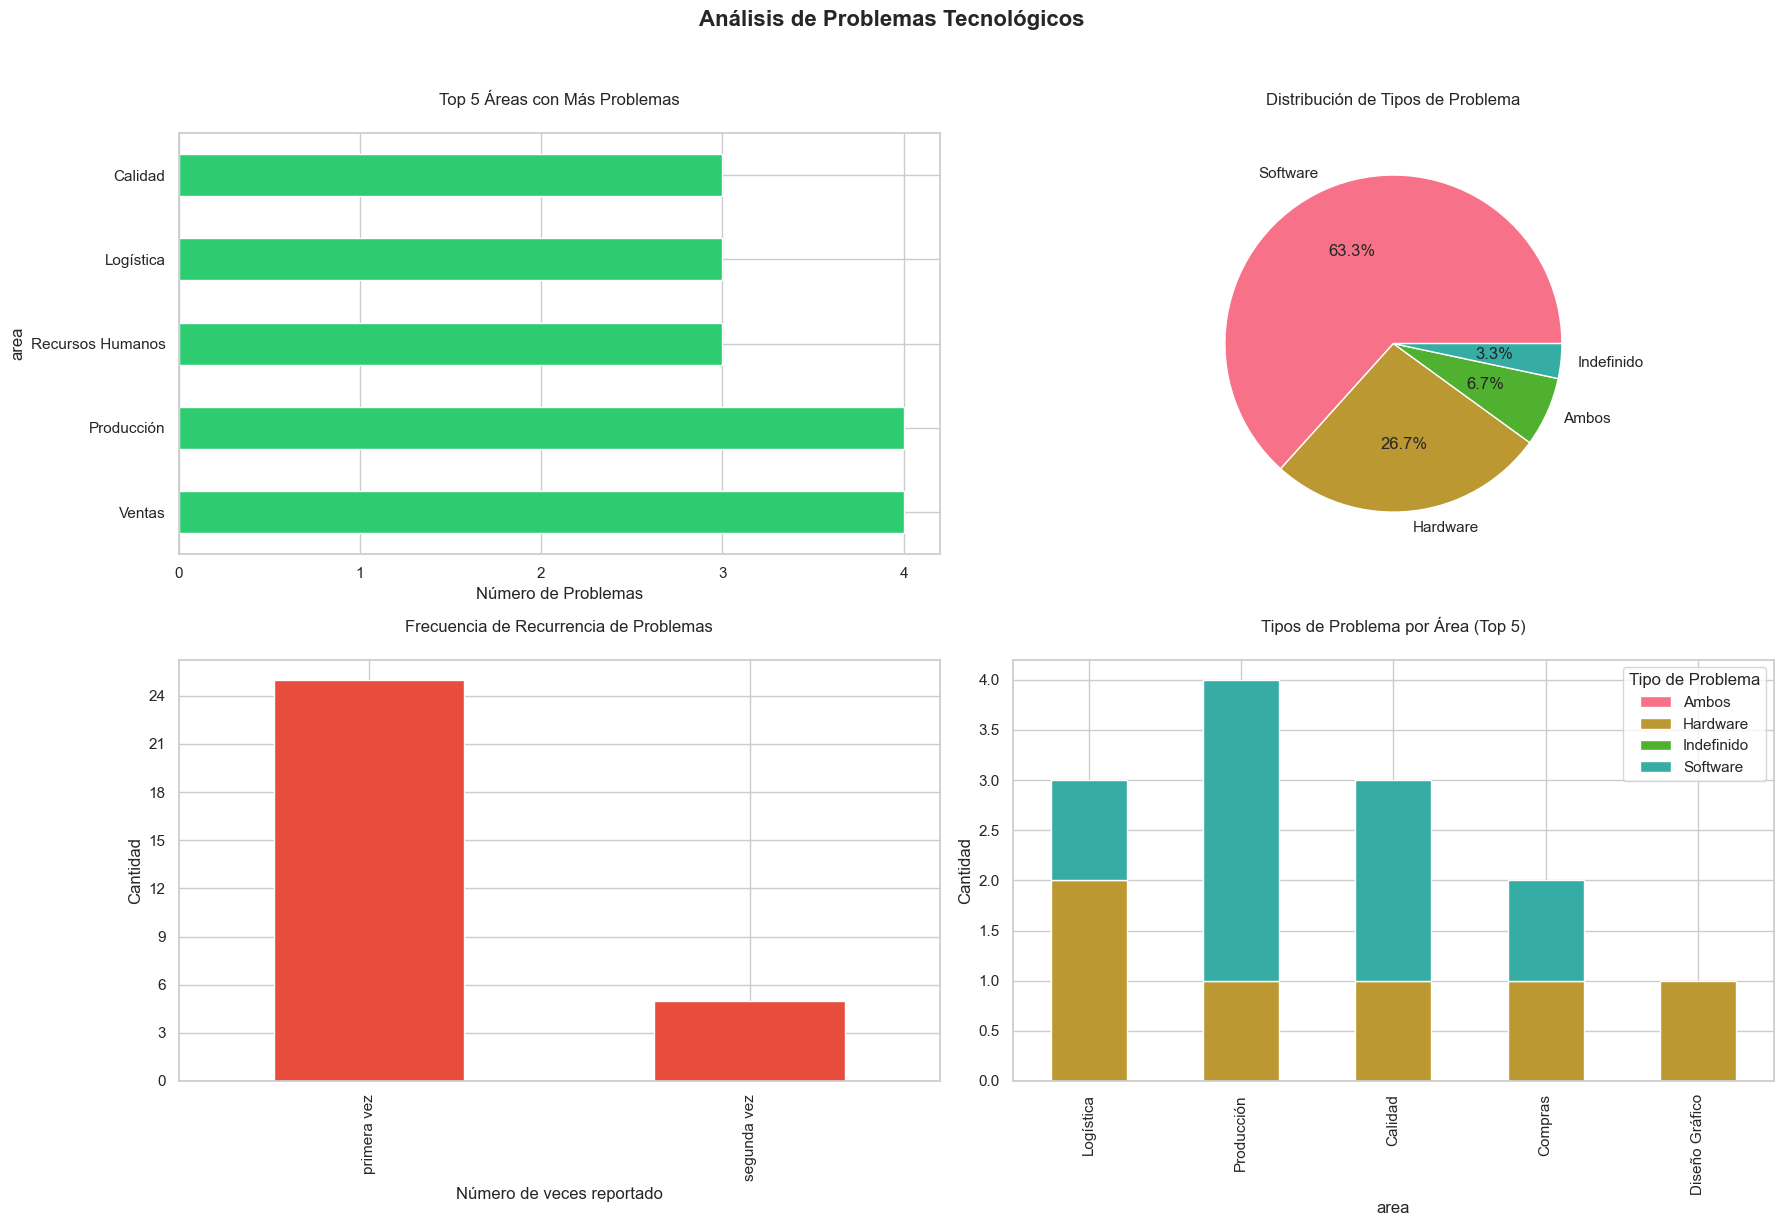


Resumen Estadístico:
- Total de problemas reportados: 30
- Área con más problemas: Ventas (4 reportes)
- Problema más común: Software (19 casos)
- Porcentaje de problemas recurrentes: 16.7%

Relaciones Clave:
- Área con más problemas recurrentes: Ventas
- Tipo de problema más recurrente: Software


In [51]:

generate_analysis_report(df)
